In [1]:
# base environment
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,roc_auc_score,f1_score

In [56]:
df = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\combined_data_standard.xlsx")
# df = pd.read_excel('merged.xlsx',index_col=0) 


In [57]:
#pd.set_option('display.max_rows', None) # 展示所有行
pd.set_option('display.max_columns', None)

In [58]:
#df.drop(["Unnamed: 0.1","Unnamed: 0.1.1",'Unnamed: 0.1.1.1','癌前病变', '良性疾病', '健康或非结肠疾病'],axis=1,inplace=True)
df

,PATIENT_ID,Age,WBC,Lym,Mon,Leu,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Leu%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,Fecal viscosity positive,Fecal viscosity's data is missing',Fecal blood test positive,Fecal blood test's data is missing',Lienteric stool positive,Lienteric stool's data is missing',Fecal RBC positive,Fecal RBC's data is missing',Fecal WBC positive,Fecal WBC's data is missing',Fecal macrophage positive,Fecal macrophage's data is missing',Fecal hardness positive,Fecal hardness's data is missing',Fecal color positive,Fecal color's data is missing',CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,K00221060,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,1.00000,22.222222,0
1,K00797289,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,1.00000,25.826446,0
2,K06570229,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1.690000,0,1,0,1,0.00000,19.531250,0
3,01828787,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,0.63176,23.857203,0
4,J01820164,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,JR1005648,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.699406,0,1,0,1,1.00000,28.081633,0
27907,05312402,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,0.00000,26.175195,0
27908,05681573,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.280000,0,1,0,1,1.00000,18.591130,0
27909,05809327,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000,0,0,0,0,0.00000,24.243918,0


In [59]:
df=df.head(27911)
df

,PATIENT_ID,Age,WBC,Lym,Mon,Leu,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Leu%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,Fecal viscosity positive,Fecal viscosity's data is missing',Fecal blood test positive,Fecal blood test's data is missing',Lienteric stool positive,Lienteric stool's data is missing',Fecal RBC positive,Fecal RBC's data is missing',Fecal WBC positive,Fecal WBC's data is missing',Fecal macrophage positive,Fecal macrophage's data is missing',Fecal hardness positive,Fecal hardness's data is missing',Fecal color positive,Fecal color's data is missing',CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,K00221060,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,1.00000,22.222222,0
1,K00797289,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,1.00000,25.826446,0
2,K06570229,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1.690000,0,1,0,1,0.00000,19.531250,0
3,01828787,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,0.63176,23.857203,0
4,J01820164,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,JR1005648,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.699406,0,1,0,1,1.00000,28.081633,0
27907,05312402,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,8.699406,0,1,0,1,0.00000,26.175195,0
27908,05681573,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.280000,0,1,0,1,1.00000,18.591130,0
27909,05809327,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000,0,0,0,0,0.00000,24.243918,0


In [22]:
y = np.array(df['癌'])
X = df.drop(['PATIENT_ID', '癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [23]:
class Model(PyroModule):
    def __init__(self, d_in, h1=200, h2=None):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](d_in, h1)
        # 使用 .to_event(n) 将一维分布转化成多维分布, 其中 n 表示从右边开始数 n 个维度声明 dependent, 相当于变成Multivariate Normal
        # to_event(1) 表示随机向量的维度为原来分布 batch_shape 的最后一个维度
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, d_in]).to_event(2))  # 相当于这h1个是dependent的
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1)) # 感觉把bias也变成Multi-variate
        if h2 is not None: # There is only two hidder layer
            self.fc2 = PyroModule[nn.Linear](h1, h2)
            self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
            self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        else: # There is only one hidder layer
            self.fc2 = None
            h2 = h1 
        self.out = PyroModule[nn.Linear](h2, 2) # 2 here is for the two classes
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        # x = x.reshape(len(x), -1)
        x = F.relu(self.fc1(x))
        if self.fc2 is not None:
            x = F.relu(self.fc2(x))
        x = self.out(x)  
        # print(x.shape)
        # x = x.squeeze()
        lhat = x
        # lhat = self.log_softmax(lhat)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=lhat), obs=y)
        return lhat

In [24]:
def make_prediction(X_test, X_train, model, guide, num_samples = 500):
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    preds_train = predictive(torch.from_numpy(X_train).float())
    
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    y_pred_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
    y_std_train = preds_train['obs'].T.detach().numpy().std(axis=1)
    y_pred=pd.DataFrame(y_pred)
    y_pred=y_pred.T.median().T
    y_pred
    #return y_pred, y_std, y_pred_train, y_std_train
    return y_pred_train

In [25]:
### Define Train/test spilt with K-fold
"""
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
"""

K=10
kf = KFold(n_splits=K)
for train,test in kf.split(X):
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)


In [27]:
### Define function to calculate results 
def show_result(y_test,predicted_y):
    accuracy=accuracy_score(y_test,predicted_y)
    auc_score = roc_auc_score(y_test,predicted_y)
    F1_score=f1_score(y_test,predicted_y,average='weighted')
    # conf_mat
    conf_mat = confusion_matrix(y_test,predicted_y)
    TN = conf_mat[0,0]#真阴
    FN = conf_mat[1,0]#假阴
    FP = conf_mat[0,1]#假阳
    TP = conf_mat[1,1]#真阳
    sensitivity = TP/(FN+TP)
    specificity = TN/(FP+TN)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    OR = (TP/FP)/(FN/TN)
    return [accuracy,auc_score,F1_score,sensitivity,specificity,PPV,NPV,OR]

#show_result(y_test,y_pred_class)

In [186]:
### define algorithms(BNN,XGboost,粪隐血)
def BNN_algo(X_train,X_test,y_train,y_test):
    model = Model(d_in=X_train.shape[1], h1=200, h2=None)
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    pyro.clear_param_store()
    bar = trange(2001)
    x_torch = torch.from_numpy(X_train).float()
    y_torch = torch.from_numpy(y_train).float()
    for epoch in bar:
        loss = svi.step(x_torch, y_torch)
        bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')
        
    num_samples = 101
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    y_pred = preds['obs'].T.detach().numpy()
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    y_pred_prob = np.mean(y_pred,axis=1)
    is_confident = uncertainty < 0.3
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred_prob

def BNN_algo_conf(X_train,X_test,y_train,y_test):
    model = Model(d_in=X_train.shape[1], h1=200, h2=None)
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    pyro.clear_param_store()
    bar = trange(2001)
    x_torch = torch.from_numpy(X_train).float()
    y_torch = torch.from_numpy(y_train).float()
    for epoch in bar:
        loss = svi.step(x_torch, y_torch)
        bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')
        
    num_samples = 101
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    y_pred = preds['obs'].T.detach().numpy()
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    y_pred_prob = np.mean(y_pred,axis=1)
    is_confident = uncertainty < 0.3
    result = show_result(y_test[is_confident],y_pred_class[is_confident])
    
    return result,y_pred_prob,y_test[is_confident],y_pred_prob[is_confident]


def XGboostAlgo(X_train,X_test,y_train,y_test):
    classfier_model = XGBClassifier(max_depth=2)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

def LogisticAlgo(X_train,X_test,y_train,y_test):
    classfier_model = LogisticRegression()
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred


def FOBAlgo(y_train,y_test):
    X_train=df[["FIT positive",r"FIT's data is missing'"]].loc[train, :]
    X_test=df[["FIT positive",r"FIT's data is missing'"]].loc[test, :]
    classfier_model =XGBClassifier(max_depth=500)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

In [270]:
classfier_model =XGBClassifier(max_depth=2)
classfier_model.fit(X_train,y_train)
y_pred_class = classfier_model.predict_proba(X_test)

y_pred_class

[10:17:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[0.9873462 , 0.01265384],
       [0.953292  , 0.04670796],
       [0.49887955, 0.50112045],
       ...,
       [0.9416346 , 0.0583654 ],
       [0.981269  , 0.01873098],
       [0.8534316 , 0.14656842]], dtype=float32)

In [187]:
### The best one in K-fold
m=[];
for train,split in kf.split(X):
    m.append([train,split])
train=m[6][0]
test=m[6][1]

X_train=X.loc[train, :]
X_test=X.loc[test,:]
y_train=y[train]
y_test=y[test]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

#result,y_pred_class_BNN = BNN_algo(X_train,X_test,y_train,y_test)
#result,y_pred_class_XGB = XGboostAlgo(X_train,X_test,y_train,y_test)
#result,y_pred_class_FOB = FOBAlgo(y_train,y_test)
result,y_pred_class_BNN_confident,y_test_confident,y_pred_class_confident = BNN_algo_conf(X_train,X_test,y_train,y_test)
#result

  0%|          | 0/2001 [00:00<?, ?it/s]

In [109]:
results = [];
K=10
#kf = KFold(n_splits=K)
for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)
    
    #result,y_pred_class = BNN_algo(X_train,X_test,y_train,y_test)
    #result,y_pred_class = XGboostAlgo(X_train,X_test,y_train,y_test)
    #result,y_pred_class = FOBAlgo(y_train,y_test)
    
    #results.append(result)
    

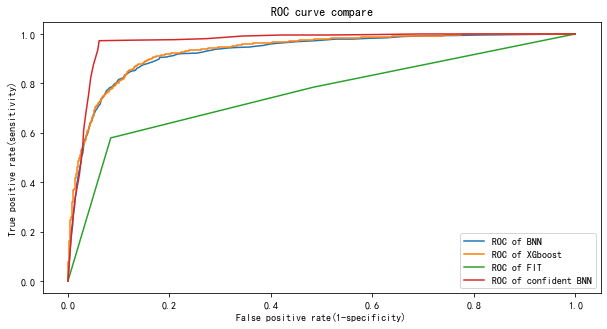

In [188]:
fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test, y_pred_class_BNN)
fpr_2, tpr_2, thresholds = metrics.roc_curve(y_test, y_pred_class_XGB[:,1]) #XGBoost
fpr_3, tpr_3, thresholds = metrics.roc_curve(y_test, y_pred_class_FOB[:,1]) #FOB
fpr_4, tpr_4, thresholds = metrics.roc_curve(y_test_confident,y_pred_class_confident) #BNN on confident data
#roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#plt.plot(fpr_3,tpr_3)

f, ax= plt.subplots(figsize = (10, 5))
fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN")
fig=plt.plot(fpr_2,tpr_2,label="ROC of XGboost")
fig=plt.plot(fpr_3,tpr_3,label="ROC of FIT")
fig=plt.plot(fpr_4,tpr_4,label="ROC of confident BNN")

# 设置Axes的标题
ax.set_title('ROC curve compare')
ax.set_xlabel("False positive rate(1-specificity)")
ax.set_ylabel("True positive rate(sensitivity)")
ax.legend()
plt.show()

In [161]:
a=np.array(results)
a[:,7].mean()
x=pd.DataFrame(a)
x.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\3. results\method_compare.xlsx")

In [105]:
results = [];
K=10
kf = KFold(n_splits=K)
for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    
    results.append(result)

NameError: name 'result' is not defined

In [167]:
model = Model(d_in=X_train.shape[1], h1=200, h2=None)
guide = AutoDiagonalNormal(model)
optim = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(2001)
x_torch = torch.from_numpy(X_train).float()
y_torch = torch.from_numpy(y_train).float()
for epoch in bar:
    loss = svi.step(x_torch, y_torch)
    bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')


  0%|          | 0/2001 [00:00<?, ?it/s]

In [168]:
num_samples = 101
predictive = Predictive(model, guide=guide, num_samples=num_samples)

In [169]:
preds = predictive(torch.from_numpy(X_test).float())

In [170]:
y_pred = preds['obs'].T.detach().numpy()
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

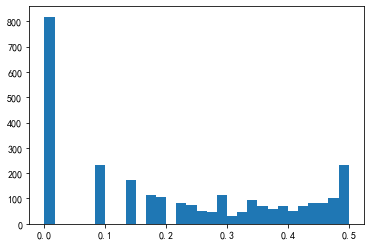

In [171]:
uncertainty = np.std(y_pred, axis=1)
plt.hist(uncertainty, bins=30)
plt.show()

In [172]:
y_pred_class = np.median(y_pred,axis=1)
y_pred_class

array([0., 0., 0., ..., 0., 0., 1.])

In [173]:
uncertainty = np.std(y_pred, axis=1)
is_confident = uncertainty < 0.3
print(sum(is_confident)/len(uncertainty))

0.6456467216051595


In [174]:
not_confident = uncertainty > 0.3

In [175]:
print('test_acc:',np.sum((y_pred_class - y_test) == 0)/len(y_test))

test_acc: 0.8663561447509853


In [176]:
print('test_acc using softmax and average:',np.sum((y_pred_class[is_confident] - y_test[is_confident]) == 0)/sum(is_confident))

test_acc using softmax and average: 0.9495005549389567


In [445]:
###比较confidence level对于BNN的影响
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

full_results = [];
confident_results = [];
unconfident_results = [];
confidence_ratio = [];

for i in range(45):
    confidence_level = i*0.01+0.05
    
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    full_results.append(result)
    confident_results.append(conf_result)
    unconfident_results.append(unco_result)
    confidence_ratio.append(ratio)
    

  0%|          | 0/2001 [00:00<?, ?it/s]

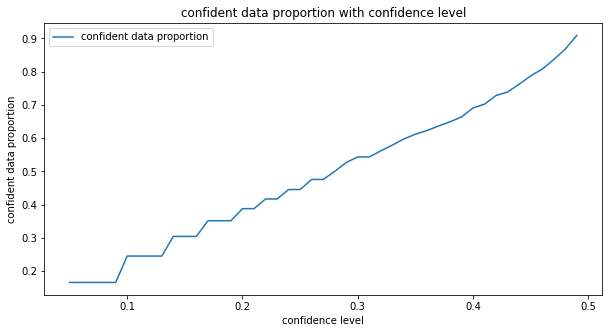

In [475]:
###plot the relation between BNN confident performance and confidence level
a=np.array(confident_results)
#print(a[:,0],confidence_ratio)

x=[]
for i in range(45):
    x.append(0.01*i+0.05)

f, ax= plt.subplots(figsize = (10, 5))
fig=plt.plot(x,confidence_ratio,label="confident data proportion")
ax.set_title('confident data proportion with confidence level')
ax.set_xlabel("confidence level")
ax.set_ylabel("confident data proportion")
ax.legend()
plt.show()

In [476]:
confidence_level = 0.3

confident_results = [];
K=10
kf = KFold(n_splits=K)


for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    confident_results.append(conf_result)

s=pd.DataFrame(confident_results)
s.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\3. results\confident patients\confident_vs_all.xlsx")

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [358]:
###比较BNN，XGB和Logistics的confident data

def calculate_uncertainty(prob_pos):
    uncertainty = [];
    for i in range(len(prob_pos)):
        ones = int(prob_pos[i]*100)
        zeros = 100 - ones 
        a = np.zeros(zeros)
        b = np.ones(ones)
        uncertainty.append(np.std(np.concatenate([a,b])))
    return np.array(uncertainty)


result,y_pred = XGboostAlgo(X_train,X_test,y_train,y_test)
#result,y_pred = LogisticAlgo(X_train,X_test,y_train,y_test)


uncertainty = calculate_uncertainty(y_pred[:,0])
y_pred_class = np.around(y_pred[:,1])

confidence_level = 0.45
is_confident = uncertainty <= confidence_level
not_confident = uncertainty > confidence_level
ratio = sum(is_confident)/len(uncertainty)
    
result = show_result(y_test,y_pred_class)
conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
print('test_acc using softmax and average:',np.sum((y_pred_class[not_confident] - y_test[not_confident]) == 0)/sum(not_confident))

test_acc using softmax and average: 0.6934579439252336


In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_test[is_confident], y_pred_class[is_confident])
metrics.auc(fpr, tpr)

0.858159594175057

In [42]:
metrics.confusion_matrix(y_test[is_confident], y_pred_class[is_confident])

array([[1361,   23],
       [  90,  247]], dtype=int64)

In [43]:
import shap

In [44]:
def Blackbox_prediction(X):
    predictive= Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X).float())
    
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    #return y_pred, y_std, y_pred_train, y_std_train
    return y_pred

In [45]:
explainer = shap.KernelExplainer(Blackbox_prediction,shap.sample(X_test,2000))
explainer.expected_value

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


0.3026732673267327

In [46]:
explainer = shap.KernelExplainer(Blackbox_prediction,shap.sample(X_train,3000))
shap_values = explainer.shap_values(X_test[0:200], nsamples=150)

# plot the SHAP values for the Setosa output of the first instance
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

In [47]:
shap_matrix=pd.DataFrame(shap_values)
shap_matrix.columns=df.iloc[:,1:-1].columns
shap_matrix

,Age,WBC,Lym,Mon,Leu,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Leu%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,Fecal viscosity positive,Fecal viscosity's data is missing',Fecal blood test positive,Fecal blood test's data is missing',Lienteric stool positive,Lienteric stool's data is missing',Fecal RBC positive,Fecal RBC's data is missing',Fecal WBC positive,Fecal WBC's data is missing',Fecal macrophage positive,Fecal macrophage's data is missing',Fecal hardness positive,Fecal hardness's data is missing',Fecal color positive,Fecal color's data is missing',CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI
0,0.000000,0.000000,0.0,0.000000,0.000000,0.013994,0.000000,0.000000,0.000000,0.061484,0.000000,0.0,0.025330,0.000000,0.000,0.00000,0.0,0.000000,0.041107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.020863,0.000000,0.000000,0.023030,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.026604,0.0,0.000000,0.000000,0.017435,0.000000,0.0,0.052317,0.000000,0.000000,0.000000,0.0,0.000000,0.036319,0.032203,0.00000,0.000000,0.000000,0.135635,0.000000,0.000000,0.132082,0.020841,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012532,0.0,0.000000,0.000000,0.000,0.00000,0.0,0.000000,0.164304,0.000000,0.000000,0.009659,0.000000,0.000000,0.000000,0.016012,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021729,0.007858,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.081141,0.000000,0.000000,0.0,0.026465,0.000000,0.000000,0.000000,0.0,0.000000,0.016609,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.02064,0.008738,0.000000,0.124080,0.000000,0.089874,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.00000,0.0,0.000000,-0.146141,0.000000,0.000000,-0.033839,0.000000,-0.048251,0.000000,0.000000,0.000000,0.000000,0.019964,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.014472,0.000000,0.0,0.000000,0.000000,-0.017365,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.050412,0.000000,0.047275,-0.088867,0.000000,0.000000
3,0.000000,0.000000,0.0,-0.021442,0.000000,0.020687,0.000000,0.000000,-0.021722,0.000000,0.000000,0.0,0.000000,0.001487,0.000,0.00000,0.0,0.012870,-0.032231,0.000000,0.000000,0.004200,0.000000,0.000000,0.000000,0.000000,0.010513,0.000000,-0.079293,0.007337,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.021910,0.000000,0.000000,0.0,0.021962,0.000000,0.000000,0.000000,0.000000,0.0,0.028078,0.000000,0.000000,0.000000,0.0,0.072887,0.000000,-0.015976,0.016354,0.0,0.020662,0.000000,0.017592,0.00000,0.000000,0.000000,0.143986,0.020678,-0.037233,0.103422,0.000000,0.000000
4,0.000000,-0.002360,0.0,0.000000,0.000000,-0.006892,-0.008521,-0.020226,0.000000,0.000000,0.000000,0.0,-0.005264,-0.005776,0.000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.040136,0.000000,0.000000,0.000000,0.000000,-0.006492,0.000000,0.000000,0.0,-0.013684,0.0,0.000000,0.0,-0.011178,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.014763,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.042927,0.0,0.000000,0.000000,-0.015704,0.00000,0.000000,-0.005643,-0.024557,0.000000,0.000000,-0.037624,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0

In [100]:
shap_matrix=pd.DataFrame(shap_values)
shap_matrix.columns=df.iloc[:,1:-1].columns

explained_data=pd.DataFrame(X_test[0:200])
explained_data.columns=df.iloc[:,1:-1].columns
sign = explained_data.copy()
for i in tqdm(explained_data.columns):
    for j in explained_data.index:
        if explained_data[i].loc[j]>=0:
            sign[i].loc[j] = 1
        else:
            sign[i].loc[j] = -1


shap_effect=shap_matrix/sign
shap_effect=pd.DataFrame(shap_effect.mean()).T

shap_effect=shap_effect.sort_values(axis=1,by=0,ascending=False)
shap_effect

shap_matrix=abs(shap_effect)
shap_matrix=shap_matrix.sort_values(axis=1,by=0,ascending=False)
shap_matrix=shap_matrix/float(shap_matrix.sum(1))
shap_matrix.sum()

  0%|          | 0/70 [00:00<?, ?it/s]

RDW                                     0.202839
FIT positive                            0.126579
Fecal transferrin's data is missing'    0.113235
Prealbumin                              0.064349
P-LCR                                   0.030728
                                          ...   
IBIL                                    0.000551
Eos                                     0.000432
BMI                                     0.000344
Fecal WBC positive                      0.000297
Creatinine                              0.000259
Length: 70, dtype: float64

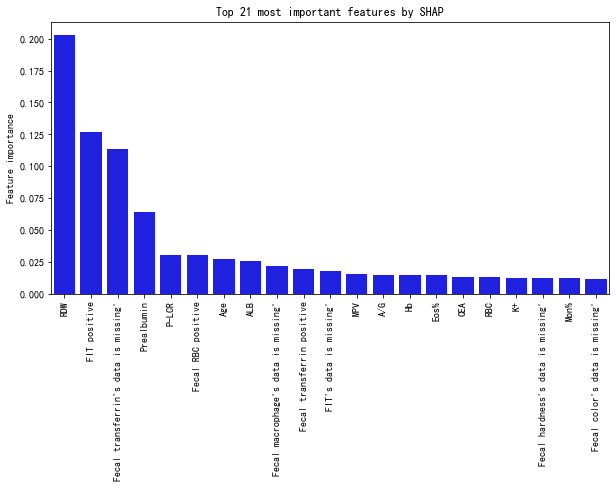

In [88]:
import seaborn as sns
important_features=list(shap_matrix.columns)[0:21]
shap_effect=shap_effect[important_features]
shap_effect.sort_values(axis=1,by=0,ascending=False,inplace=True)

f, ax= plt.subplots(figsize = (10, 5))
sns.barplot(data=shap_matrix[important_features],color="blue");

plt.xticks(rotation=90);
plt.title("Top 21 most important features by SHAP")
#plt.xticks("feature name")
ax.set_ylabel("Feature importance")

#ax.legend("average percentage change per sigma")
plt.show()

#shap_effect,shap_matrix




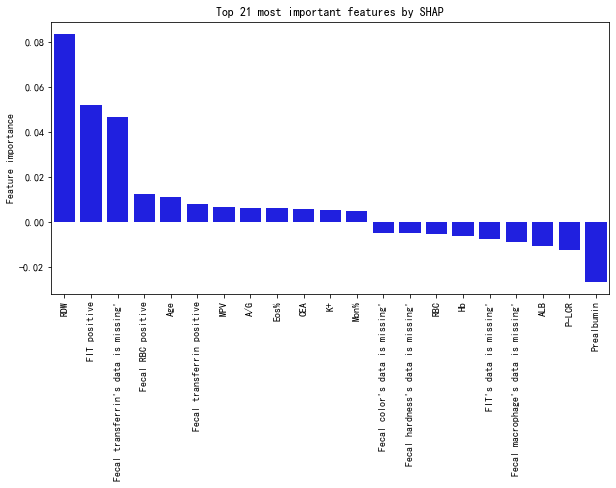

In [103]:
import seaborn as sns

shap_effect=shap_effect[important_features]
shap_effect.sort_values(axis=1,by=0,ascending=False,inplace=True)
important_features=list(shap_effect.columns)[0:21]

f, ax= plt.subplots(figsize = (10, 5))
sns.barplot(data=shap_effect[important_features],color="blue");

plt.xticks(rotation=90);
plt.title("Top 21 most important features by SHAP")
#plt.xticks("feature name")
ax.set_ylabel("Feature importance")

#ax.legend("average percentage change per sigma")
plt.show()

In [89]:
shap_effect.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\feature_effect.xlsx")
shap_matrix[important_features].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\abs_importance.xlsx")

In [65]:
useful_item=list(shap_matrix.iloc[:,0:21].columns)
useful_item

['RDW',
 'FIT positive',
 "Fecal transferrin's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Fecal RBC positive',
 'Age',
 'ALB',
 "Fecal macrophage's data is missing'",
 'Fecal transferrin positive',
 "FIT's data is missing'",
 'MPV',
 'A/G\xa0',
 'Hb',
 'Eos%',
 'CEA',
 'RBC',
 'K+',
 "Fecal hardness's data is missing'",
 'Mon%',
 "Fecal color's data is missing'"]

In [93]:
s=abs(shap_effect)
s=s.sort_values(axis=1,by=0,ascending=False)
useful_item=list(s.iloc[:,0:21].columns)
simplified_merged=df.copy()
for i in simplified_merged.iloc[:,1:-1].columns:
    if i not in useful_item:
        simplified_merged=simplified_merged.drop(i,axis=1)


In [94]:
simplified_merged

,PATIENT_ID,Age,Mon%,Eos%,RBC,Hb,RDW,MPV,P-LCR,K+,ALB,A/G,Prealbumin,Fecal RBC positive,Fecal macrophage's data is missing',Fecal hardness's data is missing',Fecal color's data is missing',CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',癌
0,K00221060,61,12.5,0.0,5.08,173.0,13.6,9.5,21.9,4.5,39.0,1.30,147.00000,0,1,1,1,8.699406,0,1,0,1,0
1,K00797289,73,4.7,1.1,4.81,149.0,12.9,10.4,28.0,4.0,47.0,1.88,192.00000,0,1,1,1,8.699406,0,1,0,1,0
2,K06570229,84,6.0,2.7,3.68,122.0,12.8,9.2,17.6,4.2,43.0,1.59,210.00000,0,1,1,1,1.690000,0,1,0,1,0
3,01828787,71,4.1,1.6,3.84,125.0,12.4,9.6,21.6,4.1,45.0,1.55,225.49881,0,1,1,1,8.699406,0,1,0,1,0
4,J01820164,80,6.5,2.1,3.06,99.0,11.6,9.2,17.7,3.8,37.0,1.42,199.00000,0,0,0,0,3.630000,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,JR1005648,56,8.2,3.1,4.24,132.0,12.0,10.5,28.6,4.1,37.0,1.48,257.00000,0,0,0,0,8.699406,0,1,0,1,0
27907,05312402,76,6.1,0.5,3.93,115.0,12.0,10.2,25.5,4.3,36.0,1.38,228.00000,0,1,1,1,8.699406,0,1,0,1,0
27908,05681573,65,12.2,8.0,4.21,126.0,13.0,13.1,50.4,3.9,40.0,1.74,213.00000,0,0,0,0,1.280000,0,1,0,1,0
27909,05809327,52,7.3,3.1,4.33,132.0,12.6,10.3,27.3,4.1,49.0,1.58,310.00000,0,0,0,0,0.750000,0,0,0,0,0


In [95]:
simplified_merged.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\simplified_data.xlsx")

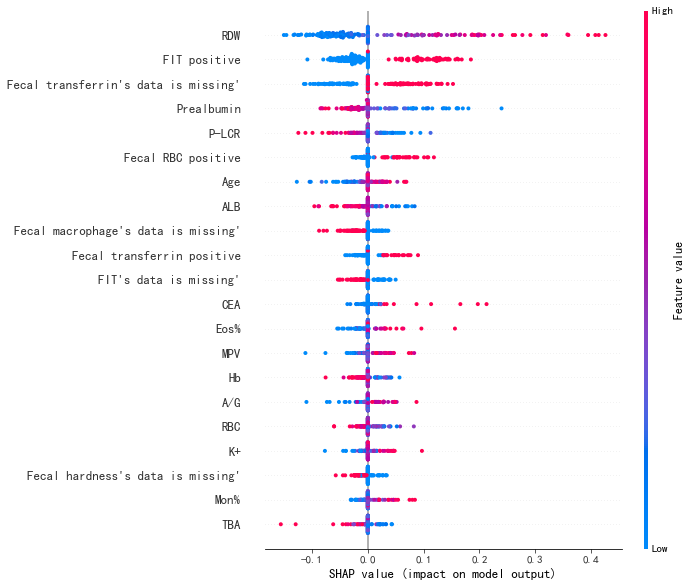

In [61]:
#rc = {'font.sans-serif': 'SimHei','axes.unicode_minus': False}

#plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
#plt.rcParams['axes.unicode_minus']=False

shap.summary_plot(shap_values, X_test[0:200],feature_names=df.iloc[:,1:-1].columns,max_display=21)

In [87]:
shap_values.sort_values(axis=1,by=0,ascending=False)

,红细胞分布宽度,单核细胞,糖类抗原CA199,钾,嗜酸粒细胞,身高,碱性磷酸酶,粪硬度正常,尿素,粪粘度异常,...,血小板压积,蛋白质数据缺失,白蛋白/球蛋白,酮体数据缺失,血小板计数,红细胞血红蛋白数据缺失,大血小板细胞比率,总蛋白,性别,粪转铁蛋白正常
0,0.028194,0.002618,0.001185,0.001138,0.001055,0.001052,0.000846,0.000743,0.000718,0.000701,...,-0.001433,-0.001519,-0.001569,-0.001575,-0.00174,-0.001743,-0.001768,-0.002267,-0.002552,-0.00301
